# **main.ipynb**

The purpose of this script is to statistically analyze the different card sets of the game *Magic: The Gathering* in order to:

1. Identify the most relevant cards in each set.
2. Compare the metadata associated with cards across different sets.

The goal of the analysis is to objectively determine the intrinsic value of a card *within* and *across* sets.

The intended application of this analysis is to leverage this data to improve performance in limited formats (*sealed, draft*).

# **Initialisation**

In [3]:
import os
import json
import re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from set_analyzer import *

from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [4]:
%load_ext autoreload
%autoreload 2

Upload data from JSON (dataset from https://mtgjson.com/)

In [6]:
# Set path of the folder containing dataset
dataset_FolderPath = Path.cwd().parent / 'datasets' / 'MTG_datasets' # @dev TBC before each use

# Set path of the File
dataset_FileName = 'AllPrintings.json'
dataset_FilePath = dataset_FolderPath / dataset_FileName

In [7]:
# Load all datasets
data = pd.read_json(dataset_FilePath)
allSets = data.iloc[2:]['data'] # 2 first rows of JSON files are metadata

In [8]:
setCompare = allSets.apply(pd.Series)[['baseSetSize', 'code', 'totalSetSize', 'type', 'name', 'releaseDate']]

# **Analysis of one set** 

In [10]:
set_code = 'OTJ'
cards = loadLimitedSet(allSets, set_code)

## 1) SPEED

Format speed can be caracterized by :
- the ratio of creatures
- the median creature `manaValue`
- the median `powerToManaValue` : above 1: creatures hit hard, fast
- the board state (see section 2)
- the number of interactions (see section 3)

In [12]:
limitedCreatureRatio, meanCreatureMV, meanPowerToMV = analyzeSetSpeed(cards)

# Add values to setCompare
setCompare = setCompare.copy()
setCompare.at[set_code, 'limited_CreatureRatio'] = limitedCreatureRatio
setCompare.at[set_code, 'limited_meanCreatureManaValue'] = meanCreatureMV
setCompare.at[set_code, 'limited_meanCreaturePowerToManaValue'] = meanPowerToMV

## 2) BOARD STATE

- the mean creature `power`
- the mean creature `thougness`
- the mean `powerToToughness ratio`: above 1: creatures are likely to hit harder and defend badly (and vice versa)
- ratio of evasive creatures (ie. 'Flying', 'Trample', 'Menace')

In [14]:
meanCreaturePower, meanCreatureToughness, meanPowerToToughness, KWCount, evasiveKWCount = analyzeSetBoardState(cards)

# Add values to setCompare
setCompare = setCompare.copy()
setCompare.at[set_code, 'limited_meanCreaturePower'] = meanCreaturePower
setCompare.at[set_code, 'limited_meanCreatureToughness'] = meanCreatureToughness
setCompare.at[set_code, 'limited_meanCreaturePowerToToughness'] = meanPowerToToughness
setCompare.at[set_code, 'limited_KWCount'] = [KWCount]
setCompare.at[set_code, 'limited_evasiveKWCount'] = [evasiveKWCount]

## 3) FIXING

- monocolor-to-multicolor ratio (lands excluded)
- multi-pip ratio : cards with more that one colored pip in mana cost
- ratio of mana producer + types (lands, manadorks, manarocks, treasures)
- type of mana produced (TBD)

In [16]:
monocolorToMulticolorRatio, multiPipRatio, manaProducerRatio, nonLand_manaProducerRatio, manaProducerTypes = analyzeSetFixing(cards)

# Add values to setCompare
setCompare = setCompare.copy()
setCompare.at[set_code, 'limited_MonoToMulticolorRatio'] = monocolorToMulticolorRatio
setCompare.at[set_code, 'limited_MultiPipRatio'] = multiPipRatio
setCompare.at[set_code, 'limited_manaProducerRatio'] = manaProducerRatio
setCompare.at[set_code, 'limited_nonLand_manaProducerRatio'] = nonLand_manaProducerRatio
setCompare.at[set_code, 'limited_manaProducerTypes'] = [manaProducerTypes]

## 4) Interactions (TBD)

a quel point le set est interactif ?
000 - définir ce qu'est une interaction
- ratio de permanents
- pourcentage d'interaction
- la "vitesse" de l'interaction = distribution de mana value des sorts interactifs
- type d'interaction : single-target removal + combat trick
- color pie

In [18]:
"""
# ratio of permanents

def checklist(items_wanted, items_tbc):
  return any(item in items_wanted for item in items_tbc)

permanent_index = [item for item in type_index if (item !='Instant' and item!='Sorcery')]
cards['types'][cards['types'].apply(lambda x: checklist(x,permanent_index)==False)] #non-permanent
cards['types'][cards['types'].apply(lambda x: checklist(x,permanent_index)==True)]  #permanents

print('permanent ratio = ' + str(len(cards['types'][cards['types'].apply(lambda x: checklist(x,permanent_index)==True)])/len(cards)*100) + ' %')

# get interactive cards

interaction_list = [
    'destroy',
    'exile',
    'counter',
    'target'
]

def interactive_card(str):
  if any(word in str for word in interaction_list):
    return True
  else:
    return False

cards[cards['text'].apply(interactive_card)]
"""

"\n# ratio of permanents\n\ndef checklist(items_wanted, items_tbc):\n  return any(item in items_wanted for item in items_tbc)\n\npermanent_index = [item for item in type_index if (item !='Instant' and item!='Sorcery')]\ncards['types'][cards['types'].apply(lambda x: checklist(x,permanent_index)==False)] #non-permanent\ncards['types'][cards['types'].apply(lambda x: checklist(x,permanent_index)==True)]  #permanents\n\nprint('permanent ratio = ' + str(len(cards['types'][cards['types'].apply(lambda x: checklist(x,permanent_index)==True)])/len(cards)*100) + ' %')\n\n# get interactive cards\n\ninteraction_list = [\n    'destroy',\n    'exile',\n    'counter',\n    'target'\n]\n\ndef interactive_card(str):\n  if any(word in str for word in interaction_list):\n    return True\n  else:\n    return False\n\ncards[cards['text'].apply(interactive_card)]\n"

# **Comparing sets**

In [20]:
# toutes les stats interset

# mettre en input le nombre et la temporalité des sets à comparer (tout le modern, 4 derniers sets, etc)
# écrire une ligne d'input

# appeler les fonctions précédentes
# ranger dans des listes / df pour faire les statistiques ensuite

In [21]:
sets = ['FDN','DSK', 'BLB', 'MH3', 'OTJ', 'MKM', 'LCI', 'WOE', 'CMM', 'LTR']

for set_code in tqdm(sets):   
    cards = loadLimitedSet(allSets, set_code)
    limitedCreatureRatio, meanCreatureMV, meanPowerToMV = analyzeSetSpeed(cards)
    meanCreaturePower, meanCreatureToughness, meanPowerToToughness, KWCount, evasiveKWCount = analyzeSetBoardState(cards)
    monocolorToMulticolorRatio, multiPipRatio, manaProducerRatio, nonLand_manaProducerRatio, manaProducerTypes = analyzeSetFixing(cards)

    # Add values to setCompare
    setCompare = setCompare.copy()
    setCompare.at[set_code, 'limited_CreatureRatio'] = limitedCreatureRatio
    setCompare.at[set_code, 'limited_meanCreatureManaValue'] = meanCreatureMV
    setCompare.at[set_code, 'limited_meanCreaturePowerToManaValue'] = meanPowerToMV
    setCompare.at[set_code, 'limited_meanCreaturePower'] = meanCreaturePower
    setCompare.at[set_code, 'limited_meanCreatureToughness'] = meanCreatureToughness
    setCompare.at[set_code, 'limited_meanCreaturePowerToToughness'] = meanPowerToToughness
    setCompare.at[set_code, 'limited_KWCount'] = [KWCount]
    setCompare.at[set_code, 'limited_evasiveKWCount'] = [evasiveKWCount]
    setCompare.at[set_code, 'limited_MonoToMulticolorRatio'] = monocolorToMulticolorRatio
    setCompare.at[set_code, 'limited_MultiPipRatio'] = multiPipRatio
    setCompare.at[set_code, 'limited_manaProducerRatio'] = manaProducerRatio
    setCompare.at[set_code, 'limited_nonLand_manaProducerRatio'] = nonLand_manaProducerRatio
    setCompare.at[set_code, 'limited_manaProducerTypes'] = [manaProducerTypes]

100%|██████████| 10/10 [00:00<00:00, 23.05it/s]


In [22]:
setCompare.loc[sets].sort_values(by='releaseDate', ascending=False)

,baseSetSize,code,totalSetSize,type,name,releaseDate,limited_CreatureRatio,limited_meanCreatureManaValue,limited_meanCreaturePowerToManaValue,limited_meanCreaturePower,limited_meanCreatureToughness,limited_meanCreaturePowerToToughness,limited_KWCount,limited_evasiveKWCount,limited_MonoToMulticolorRatio,limited_MultiPipRatio,limited_manaProducerRatio,limited_nonLand_manaProducerRatio,limited_manaProducerTypes
FDN,291,FDN,730,core,Foundations,2024-11-15,58.115183,3.189189,0.819605,2.522523,2.495495,1.161061,"[{'Flying': 22, 'Flash': 7, 'Raid': 6, 'Survei...","[{'Flying': 22, 'Trample': 2, 'Menace': 1}]",5.617978,20.786517,10.994764,4.712042,"[{'Lands': 12, 'Dorks': 2, 'Rocks': 1, 'Treasu..."
DSK,286,DSK,451,expansion,Duskmourn: House of Horror,2024-09-27,49.509804,3.207921,0.925318,2.792079,2.960396,1.105446,"[{'Flying': 13, 'Eerie': 12, 'Survival': 10, '...","[{'Flying': 13, 'Trample': 4, 'Menace': 4}]",11.398964,21.243523,7.843137,2.941176,"[{'Lands': 10, 'Dorks': 2, 'Rocks': 1, 'Treasu..."
BLB,281,BLB,397,expansion,Bloomburrow,2024-08-02,57.142857,3.096154,0.803860,2.436893,2.621359,1.066505,"[{'Flying': 17, 'Offspring': 10, 'Valiant': 8,...","[{'Flying': 17, 'Trample': 7, 'Menace': 6}]",12.000000,21.714286,7.692308,3.846154,"[{'Lands': 7, 'Dorks': 5, 'Rocks': 1, 'Treasur..."
MH3,303,MH3,560,draft_innovation,Modern Horizons 3,2024-06-14,45.739910,3.382353,0.743293,2.465347,2.613861,1.061710,"[{'Devoid': 17, 'Flying': 17, 'Adapt': 9, 'Rea...","[{'Flying': 17, 'Trample': 4, 'Menace': 5}]",17.021277,30.319149,26.008969,10.313901,"[{'Lands': 35, 'Dorks': 15, 'Rocks': 3, 'Treas..."
OTJ,286,OTJ,374,expansion,Outlaws of Thunder Junction,2024-04-19,55.497382,3.103774,0.826774,2.509434,2.783019,1.030680,"[{'Plot': 17, 'Flying': 16, 'Saddle': 10, 'Rea...","[{'Flying': 16, 'Trample': 4, 'Menace': 1}]",11.363636,18.181818,14.136126,6.282723,"[{'Lands': 15, 'Dorks': 4, 'Rocks': 1, 'Treasu..."
MKM,286,MKM,457,expansion,Murders at Karlov Manor,2024-02-09,52.150538,3.391753,0.756382,2.515464,2.824742,1.042609,"[{'Disguise': 28, 'Flying': 17, 'Investigate':...","[{'Flying': 17, 'Trample': 2, 'Menace': 1}]",21.978022,29.670330,4.838710,3.225806,"[{'Lands': 3, 'Dorks': 4, 'Rocks': 2, 'Treasur..."
LCI,291,LCI,471,expansion,The Lost Caverns of Ixalan,2023-11-17,51.376147,3.187500,0.901483,2.790909,2.900901,1.098398,"[{'Flying': 14, 'Explore': 12, 'Descend': 10, ...","[{'Flying': 14, 'Trample': 7, 'Menace': 4}]",5.392157,15.196078,11.467890,5.045872,"[{'Lands': 14, 'Dorks': 4, 'Rocks': 2, 'Treasu..."
WOE,276,WOE,453,expansion,Wilds of Eldraine,2023-09-08,50.236967,3.160377,0.831042,2.500000,2.754717,1.049438,"[{'Flying': 18, 'Role token': 12, 'Scry': 9, '...","[{'Flying': 18, 'Trample': 5, 'Menace': 4}]",14.423077,10.576923,6.161137,5.213270,"[{'Lands': 2, 'Dorks': 4, 'Rocks': 1, 'Treasur..."
CMM,451,CMM,1068,masters,Commander Masters,2023-08-04,59.022556,4.082803,0.706655,2.901961,2.929032,1.111132,"[{'Flying': 24, 'Trample': 11, 'Vigilance': 9,...","[{'Flying': 24, 'Trample': 11, 'Menace': 1}]",3.952569,27.667984,13.909774,9.398496,"[{'Lands': 12, 'Dorks': 9, 'Rocks': 14, 'Treas..."
LTR,281,LTR,854,draft_innovation,The Lord of the Rings: Tales of Middle-earth,2023-06-23,50.828729,3.347826,0.774359,2.538462,2.780220,1.037703,"[{'Food': 10, 'Flying': 10, 'Scry': 8, 'Amass'...","[{'Flying': 10, 'Trample': 4, 'Menace': 3}]",11.235955,15.730337,6.077348,4.419890,"[{'Lands': 3, 'Dorks': 3, 'Rocks': 1, 'Treasur..."


In [23]:
set_sample = setCompare.loc[sets].sort_values(by='releaseDate', ascending=False)

In [24]:
set_sample = set_sample[
    ['limited_CreatureRatio', 
     'limited_meanCreaturePower', 
     'limited_meanCreatureToughness', 
     'limited_meanCreaturePowerToToughness', 
     'limited_nonLand_manaProducerRatio']
]

set_sample

,limited_CreatureRatio,limited_meanCreaturePower,limited_meanCreatureToughness,limited_meanCreaturePowerToToughness,limited_nonLand_manaProducerRatio
FDN,58.115183,2.522523,2.495495,1.161061,4.712042
DSK,49.509804,2.792079,2.960396,1.105446,2.941176
BLB,57.142857,2.436893,2.621359,1.066505,3.846154
MH3,45.739910,2.465347,2.613861,1.061710,10.313901
OTJ,55.497382,2.509434,2.783019,1.030680,6.282723
MKM,52.150538,2.515464,2.824742,1.042609,3.225806
LCI,51.376147,2.790909,2.900901,1.098398,5.045872
WOE,50.236967,2.500000,2.754717,1.049438,5.213270
CMM,59.022556,2.901961,2.929032,1.111132,9.398496
LTR,50.828729,2.538462,2.780220,1.037703,4.419890


In [60]:
#min-max scaler
scaler1 = MinMaxScaler()
#set_sample[['limited_CreatureRatio', 'limited_meanCreaturePower', 'limited_meanCreatureToughness', 'limited_meanCreaturePowerToToughness', 'limited_nonLand_manaProducerRatio']] = scaler.fit_transform(set_sample[['limited_CreatureRatio', 'limited_meanCreaturePower', 'limited_meanCreatureToughness', 'limited_meanCreaturePowerToToughness', 'limited_nonLand_manaProducerRatio']])
set_sample_norm1 = set_sample.copy()
set_sample_norm1[set_sample_norm1.select_dtypes(include='float').columns] = scaler1.fit_transform(set_sample_norm1[set_sample_norm1.select_dtypes(include='float').columns])

#z-score scaler
scaler2 = StandardScaler()
set_sample_norm2 = set_sample.copy()
set_sample_norm2[set_sample_norm2.select_dtypes(include='float').columns] = scaler2.fit_transform(set_sample_norm2[set_sample_norm2.select_dtypes(include='float').columns])

In [58]:
set_sample_norm1

,limited_CreatureRatio,limited_meanCreaturePower,limited_meanCreatureToughness,limited_meanCreaturePowerToToughness,limited_nonLand_manaProducerRatio
FDN,0.931687,0.184122,0.000000,1.000000,0.240191
DSK,0.283821,0.763730,1.000000,0.573440,0.000000
BLB,0.858485,0.000000,0.270733,0.274770,0.122747
MH3,0.000000,0.061181,0.254605,0.237997,1.000000
OTJ,0.734603,0.155979,0.618462,0.000000,0.453231
MKM,0.482632,0.168945,0.708209,0.091493,0.038606
LCI,0.424331,0.761214,0.872026,0.519388,0.285470
WOE,0.338566,0.135694,0.557585,0.143873,0.308176
CMM,1.000000,1.000000,0.932537,0.617055,0.875839
LTR,0.383118,0.218395,0.612441,0.053862,0.200565


In [62]:
set_sample_norm2

,limited_CreatureRatio,limited_meanCreaturePower,limited_meanCreatureToughness,limited_meanCreaturePowerToToughness,limited_nonLand_manaProducerRatio
FDN,1.263202,-0.478443,-1.897109,2.150628,-0.351422
DSK,-0.846241,1.246078,1.358837,0.736702,-1.103117
BLB,1.024855,-1.026267,-1.015618,-0.253304,-0.718974
MH3,-1.770358,-0.844234,-1.068129,-0.375195,2.026449
OTJ,0.621498,-0.562179,0.116571,-1.164087,0.315298
MKM,-0.198916,-0.523602,0.408782,-0.860815,-0.982298
LCI,-0.388743,1.238592,0.942161,0.557536,-0.209719
WOE,-0.667991,-0.622534,-0.081643,-0.687190,-0.138661
CMM,1.485627,1.949059,1.139180,0.881275,1.637879
LTR,-0.522932,-0.376471,0.096967,-0.985551,-0.475435


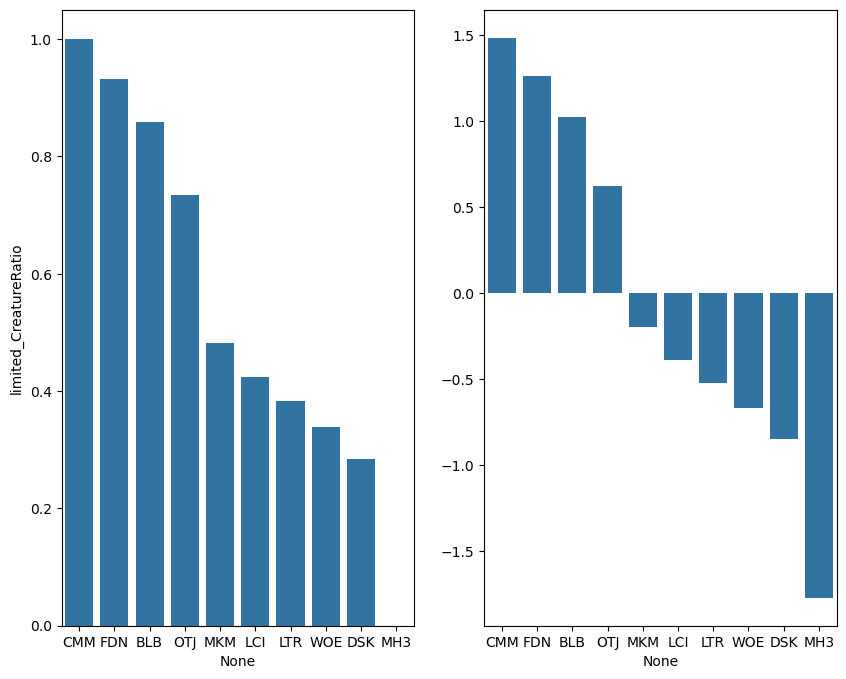

In [78]:
fig, ax = plt.subplots(1,2,figsize=(10,8))

s1 = set_sample_norm1.iloc[:,0].sort_values(ascending=False)
s2 = set_sample_norm2.iloc[:,0].sort_values(ascending=False)

sns.barplot(x=s1.index, y=s1.values, ax=ax[0])
sns.barplot(x=s2.index, y=s2.values, ax=ax[1])

ax[0].set_ylabel(set_sample_norm1.columns[0])

plt.show()